In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config
#from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config

In [30]:
num_paths = 10952

In [31]:
def get_drift_files(config):
    ts_type = "QuadSinHF" if "QuadSinHF" in config.data_path else "BiPot"
    ts_type = f"{ts_type}"
    print(ts_type)
    try:
        include =  (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
            ".", "")
    except AttributeError as e:
        include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    global_files = []
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and "DriftTrack" in file:
            if "global" in file:
                global_files.append(root_dir+file)
            elif "true" in file:
                true_files.append(root_dir+file)
            elif "local" in file:
                local_files.append(root_dir+file)
    assert len(global_files)>0, "No global files found"
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(global_files) == len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    global_files = sorted(global_files, key=extract_bw_number)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in global_files]
    return global_files, true_files, local_files, bws

In [32]:
config = get_config()
global_files, true_files, local_files, bws = get_drift_files(config=config)
global_files

BiPot


['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_00001bw_1095NPaths_00t0_3906e-03dT_025a_-05b_00c_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_00001bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_00002bw_1095NPaths_00t0_3906e-03dT_025a_-05b_00c_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_00002bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_00003bw_1095NPaths_00t0_3906e-03dT_025a_-05b_00c_global_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_00003bw_10952NPaths_00t0_3906e-03dT

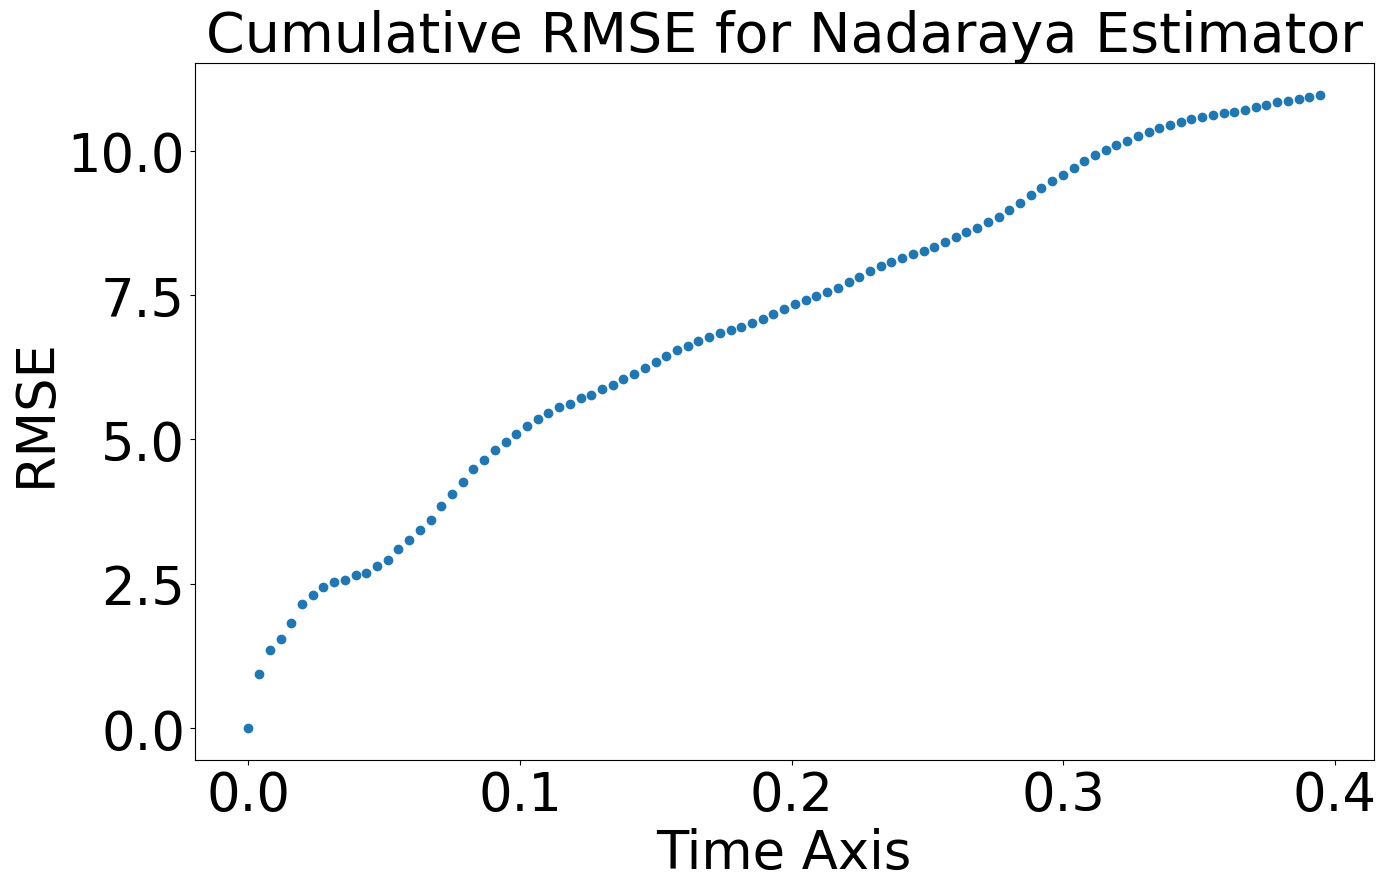

Final time cumulative RMSE local-time error 10.971380338056422 at bw 1e-05



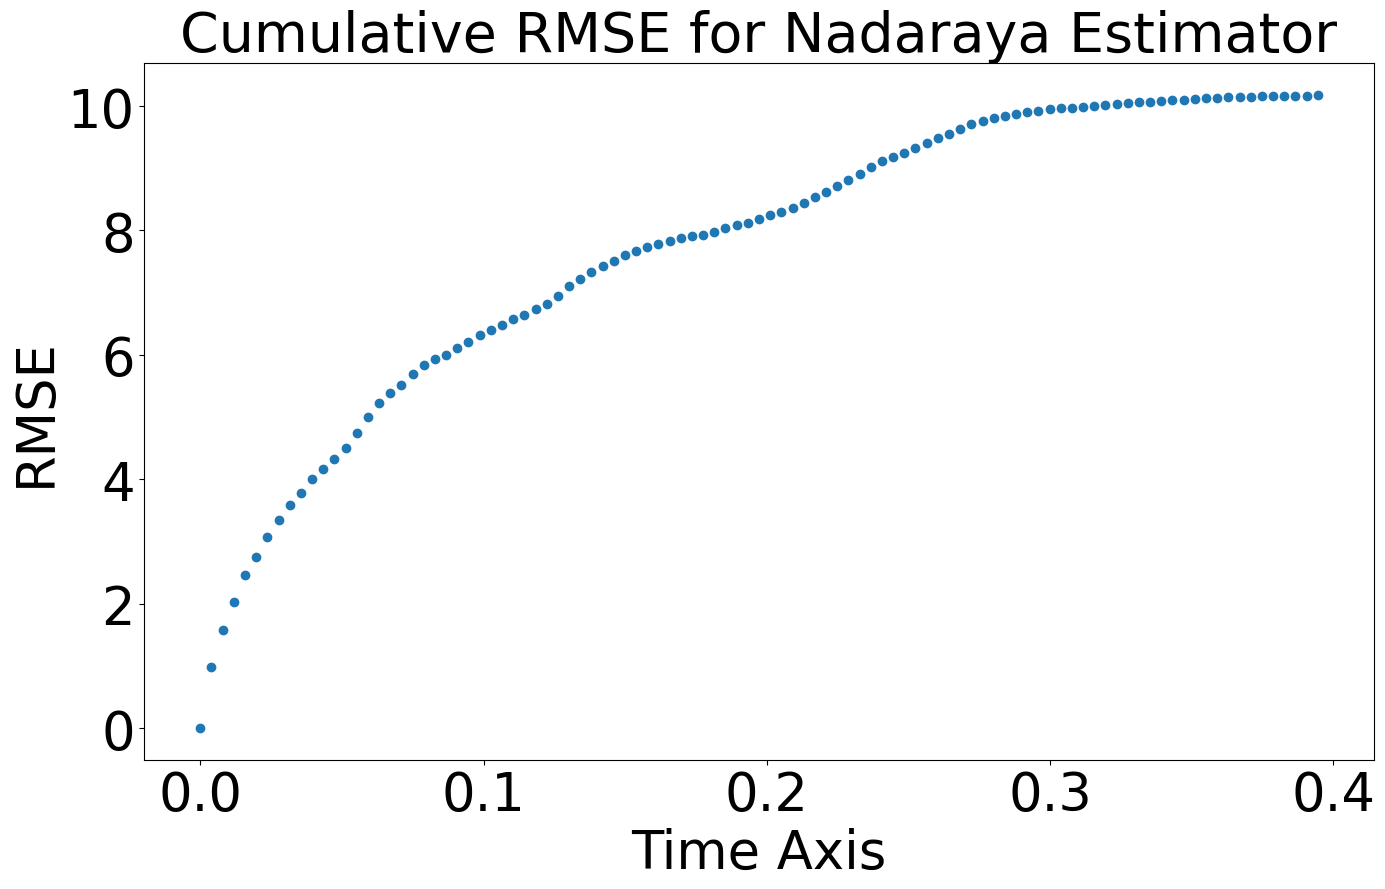

Final time cumulative RMSE local-time error 10.183682776708384 at bw 2e-05



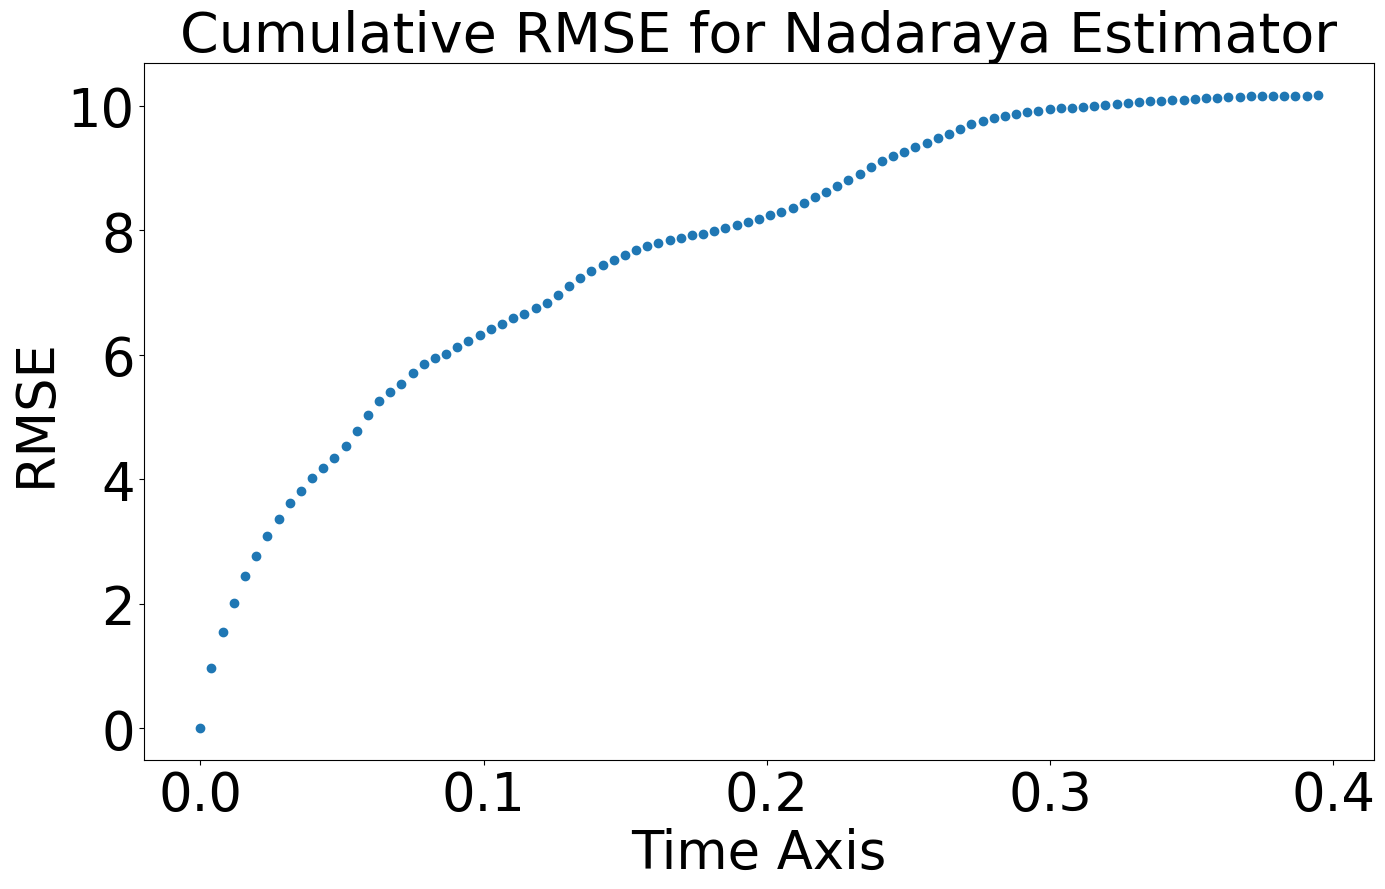

Final time cumulative RMSE local-time error 10.177610082120278 at bw 2e-05



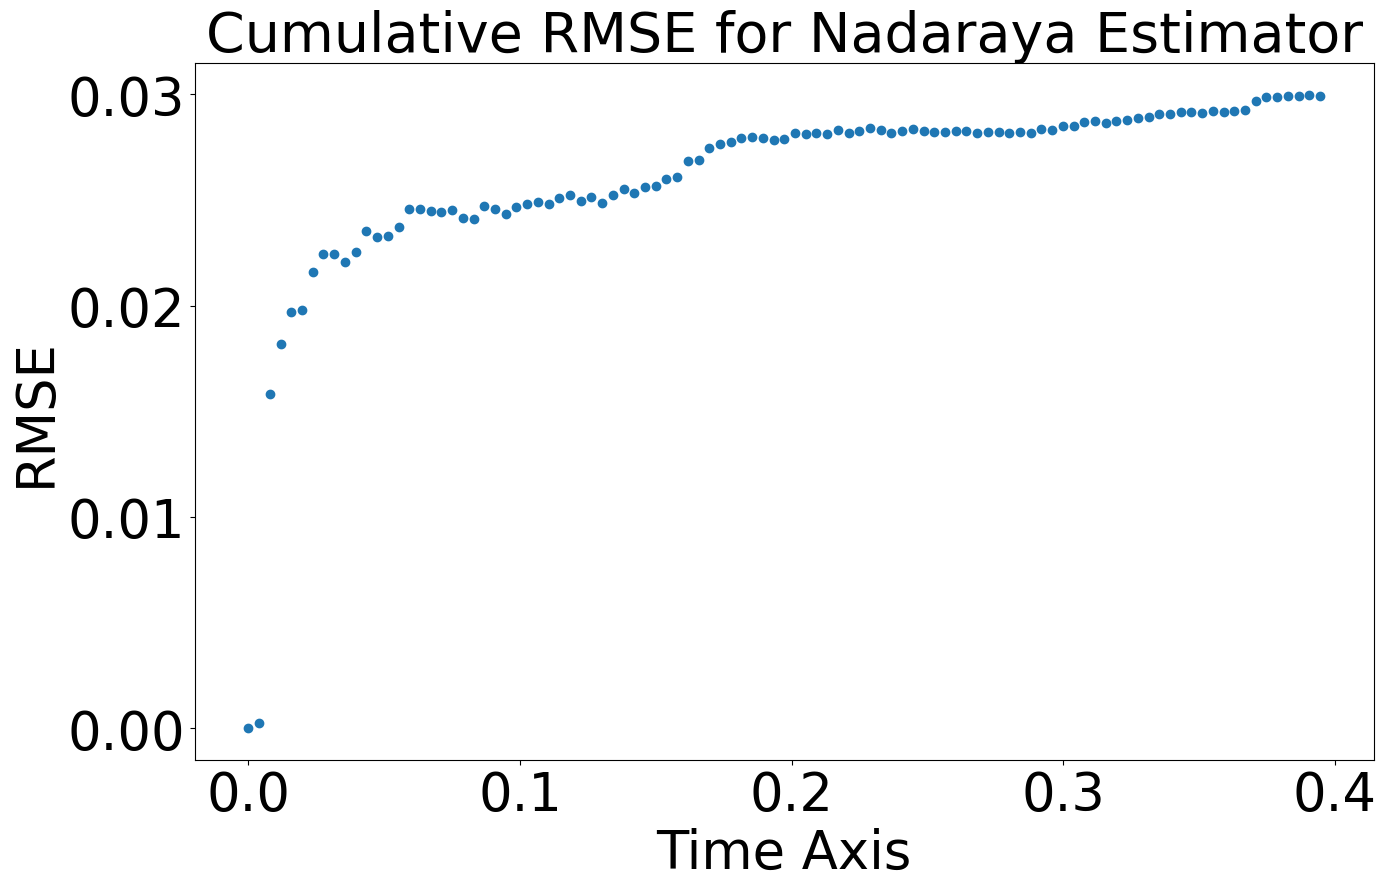

Final time cumulative RMSE local-time error 0.029904590056901968 at bw 3e-05



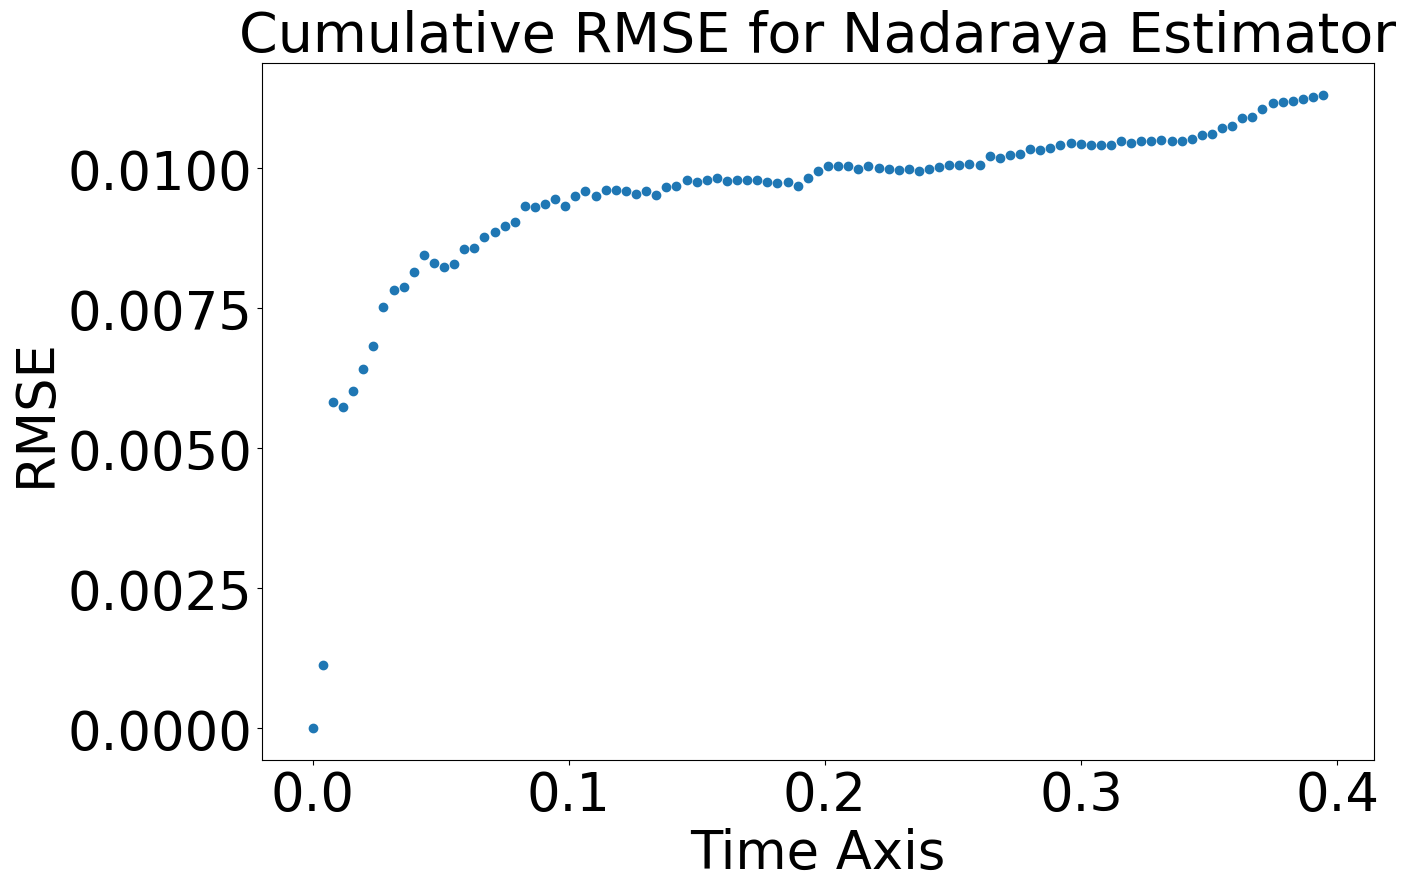

Final time cumulative RMSE local-time error 0.01131217762703573 at bw 0.00018



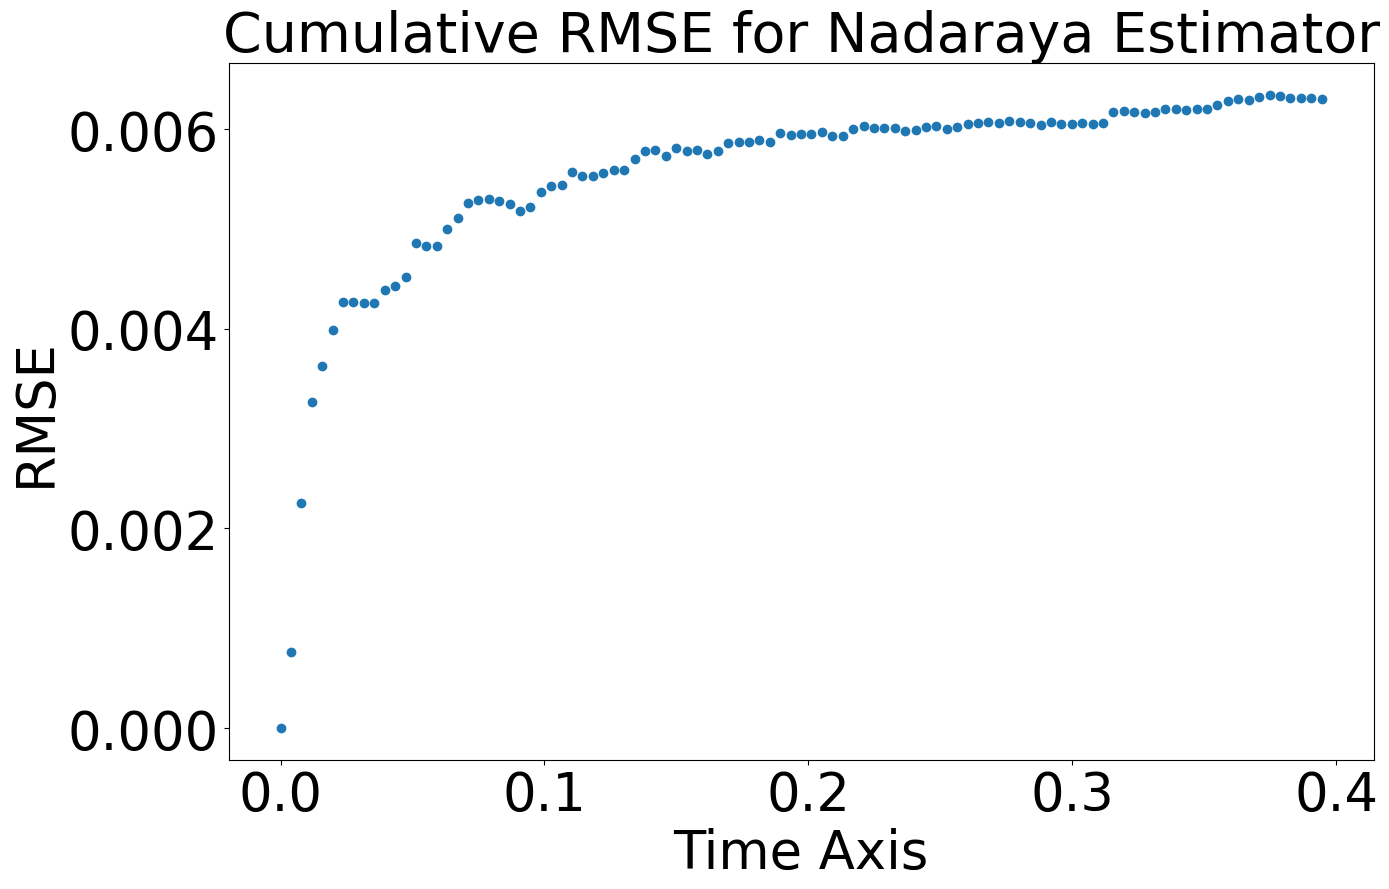

Final time cumulative RMSE local-time error 0.006302919508997151 at bw 0.00046



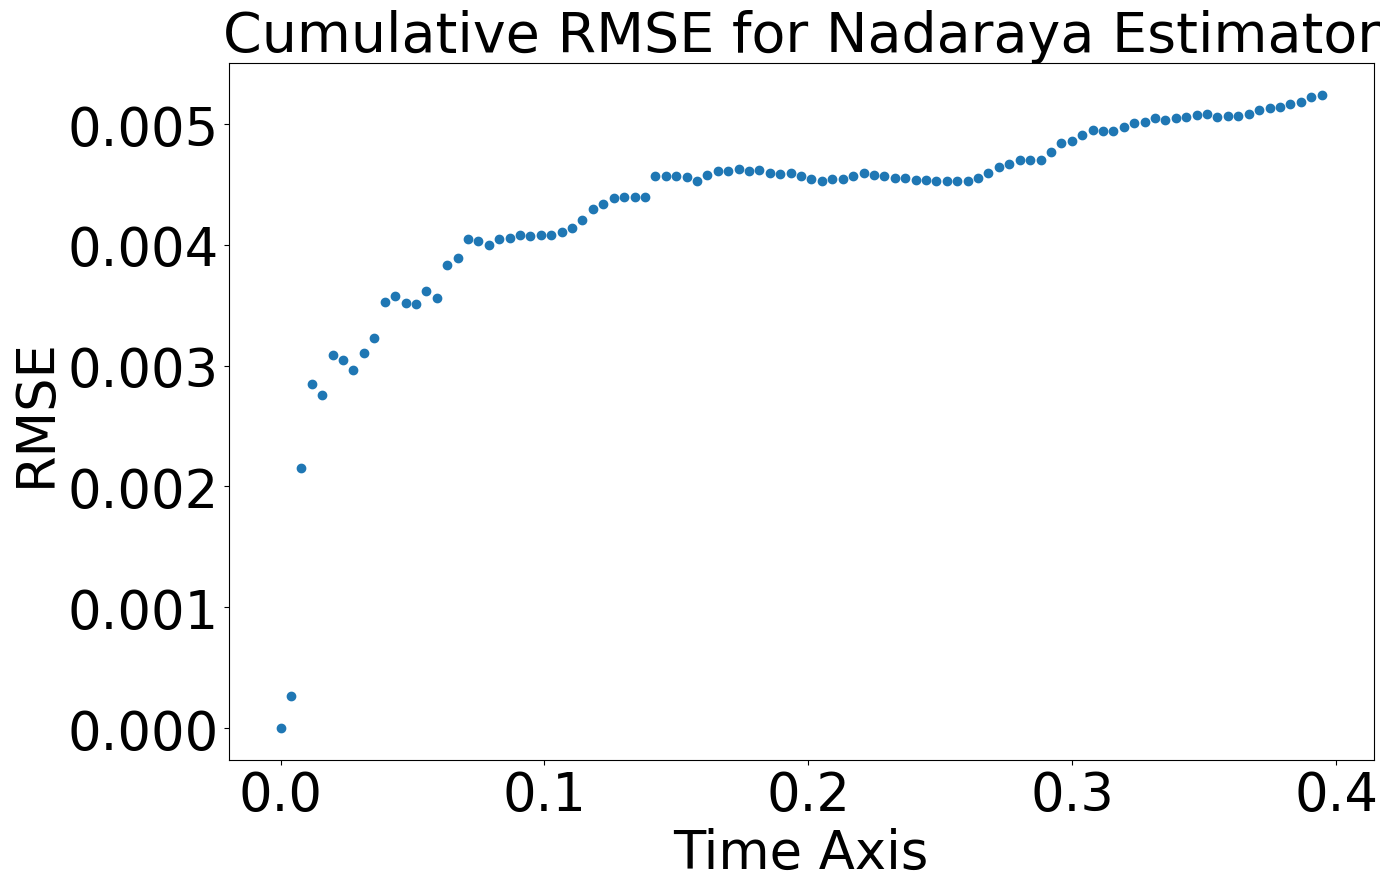

Final time cumulative RMSE local-time error 0.005244212530159259 at bw 0.00074



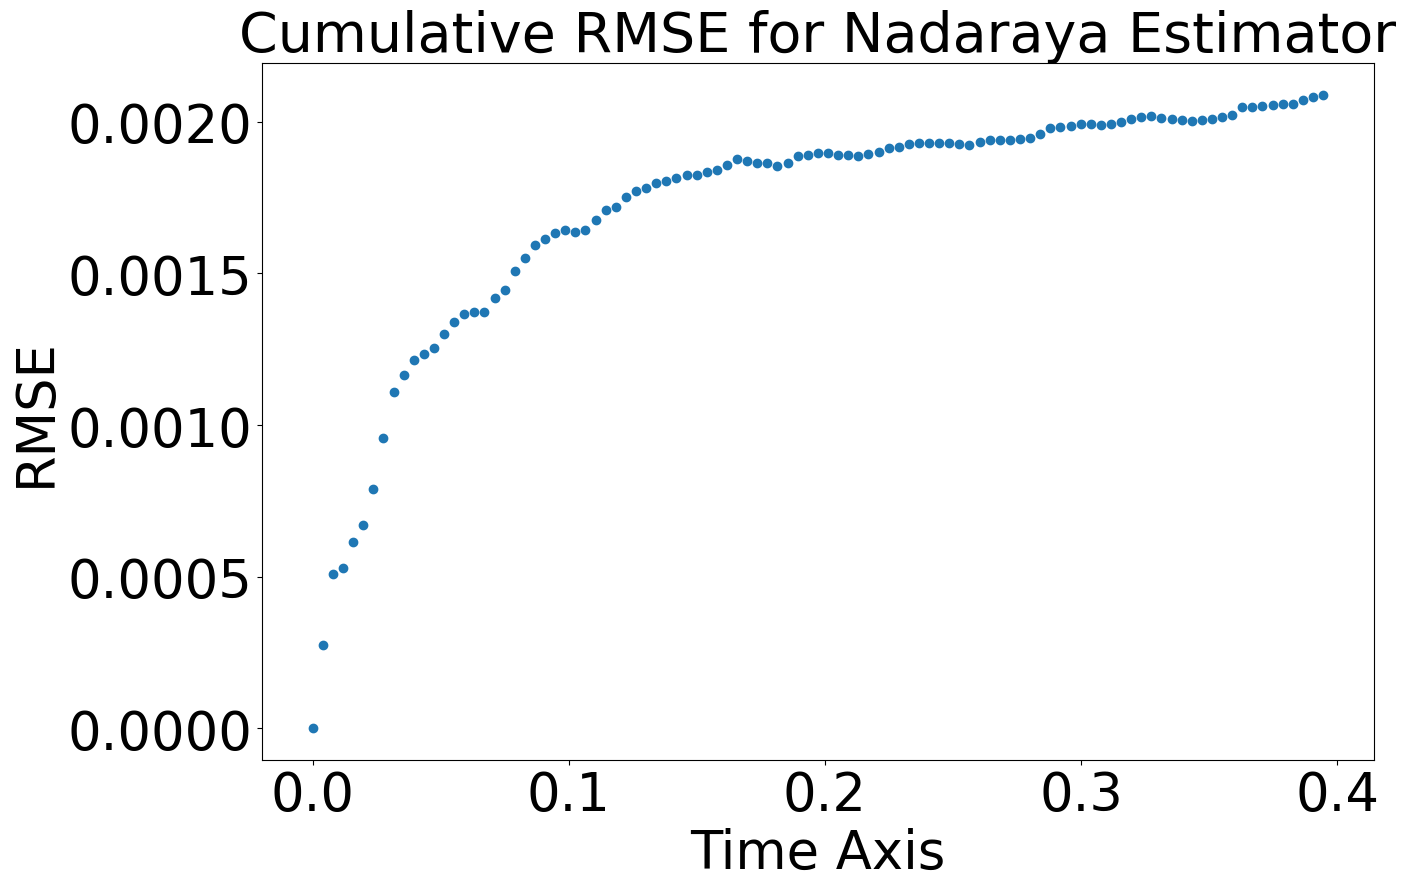

Final time cumulative RMSE local-time error 0.002090098247643519 at bw 0.00504



In [33]:
local_bw_rmses = np.inf
for file in zip(*[true_files, global_files, local_files, bws]):
    bw = file[-1]
    true_states = np.load(file[0])/np.sqrt(config.deltaT)
    global_states= np.load(file[1])/np.sqrt(config.deltaT)
    local_states = np.load(file[2])/np.sqrt(config.deltaT)
    local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5)
    total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
    if total_local_errors[-1] < local_bw_rmses:
        local_bw_rmses = total_local_errors[-1]
        fig, ax = plt.subplots(figsize=(14,9))
        total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
        ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
        ax.set_title(f"Cumulative RMSE for Nadaraya Estimator", fontsize=40)
        ax.set_ylabel("RMSE", fontsize=38)
        ax.set_xlabel("Time Axis", fontsize=38)
        ax.tick_params(labelsize=38)
        plt.tight_layout()
        plt.show()
        plt.close()
        print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} at bw {bw}\n")
